In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

module_path = os.path.abspath(os.path.join(".."))

if module_path not in sys.path:
    sys.path.append(module_path)

# move directory
os.chdir("..")

In [2]:
# Optimal control
with open("./dataset/two-stream/wo-oc/data.mat", "rb") as file:
    mdat = loadmat(file)

cost_wo = mdat["cost"]
snapshot_wo = mdat["snapshot"]

with open("./dataset/two-stream/ddpg-control/data.mat", "rb") as file:
    mdat = loadmat(file)

cost_oc = mdat["cost"]
snapshot_oc = mdat["snapshot"]

In [3]:
# Linear damping rate
from src.interpret.landau import compute_linear_damping_rate

lr_wo = compute_linear_damping_rate(50.0, 1.0, 50.0, 50.0 / 250, 250, snapshot_wo)
lr_oc = compute_linear_damping_rate(50.0, 1.0, 50.0, 50.0 / 250, 250, snapshot_oc)

print("Landau damping rate without control:{:.5f}".format(lr_wo))
print("Landau damping rate optimal control:{:.5f}".format(lr_oc))

Landau damping rate without control:0.02135
Landau damping rate optimal control:0.01816


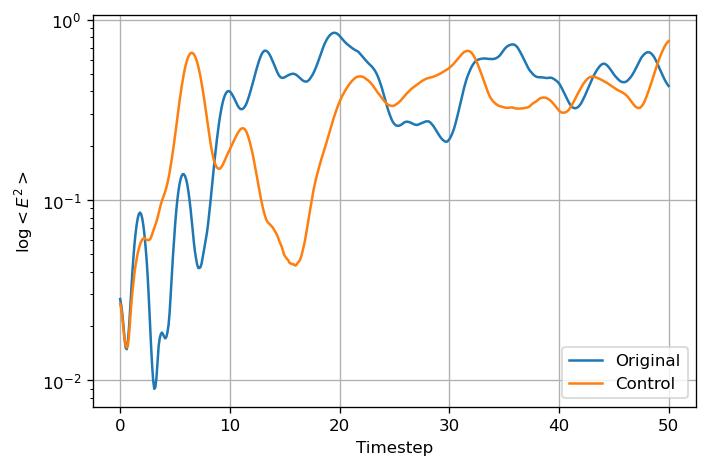

In [4]:
from src.env.util import generate_grad, generate_laplacian, compute_E

# Snapshot info
N = snapshot_oc.shape[0] // 2
Nt = snapshot_oc.shape[1]

tmax = 50
L = 50
N_mesh = 250
dx = L / N_mesh

ts = np.linspace(0,tmax,Nt)

# Gradient and Laplacian
G = generate_grad(L,N_mesh)
Lap = generate_laplacian(L,N_mesh)

E_real_list = [compute_E(snapshot_wo[:,i].reshape(-1,1), dx, N_mesh, 1.0, L, N, G, Lap)[1] for i in range(Nt)]
E2_real_wo = np.array([np.mean(E_real_list[i].ravel() ** 2) for i in range(Nt)])

E_real_list = [compute_E(snapshot_oc[:,i].reshape(-1,1), dx, N_mesh, 1.0, L, N, G, Lap)[1] for i in range(Nt)]
E2_real_oc = np.array([np.mean(E_real_list[i].ravel() ** 2) for i in range(Nt)])

fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="white", dpi=120)

ax.plot(ts, E2_real_wo, label=r'Original')
ax.plot(ts, E2_real_oc, label=r"Control")
ax.set_xlabel("Timestep")
ax.set_ylabel(r"$\log <E^2>$")
ax.grid(True)
ax.legend()
ax.set_yscale("log")
fig.tight_layout()

plt.savefig("./result/two-stream/log_E.pdf", dpi=120)

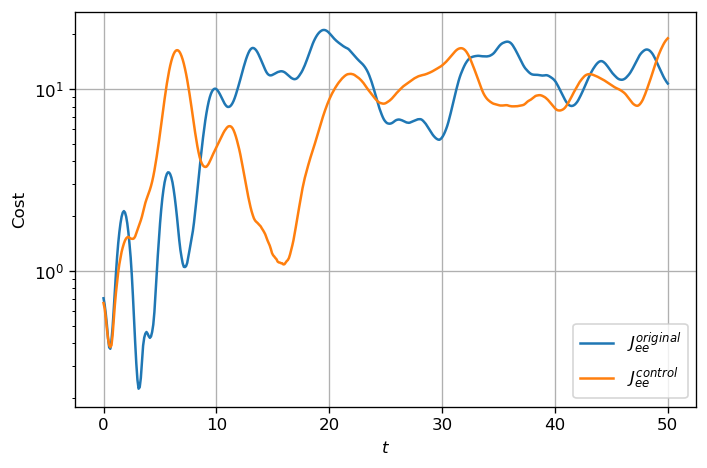

In [5]:
ts = np.linspace(0, tmax, Nt)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="white", dpi=120)

ax.plot(ts, cost_wo[r"$J_{ee}$"][0][0].ravel(), label=r"$J_{ee}^{original}$")
ax.plot(ts, cost_oc[r"$J_{ee}$"][0][0].ravel(), label=r"$J_{ee}^{control}$")
# ax.plot(ts, cost_oc[r"$J_{ie}$"][0][0].ravel(), label=r"$J_{ie}^{control}$")

ax.set_xlabel(r"$t$")
ax.set_ylabel("Cost")
ax.set_yscale("log")
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.savefig("./result/bump-on-tail/cost.pdf", dpi=120)